### Importamos librerias

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.svm import SVC
from scipy import stats
%matplotlib inline

### Cargamos datasets

In [118]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


### Reemplazamos valores nulos en las columnas de Age,Fare y Embarked

In [120]:
df.Age.fillna(value=df.Age.mean(), inplace=True)
df.Fare.fillna(value=df.Fare.mean(), inplace=True)
df.Embarked.fillna(value=df['Embarked'].value_counts().idxmax(), inplace=True)

df_test.Age.fillna(value=df_test.Age.mean(), inplace=True)
df_test.Fare.fillna(value=df_test.Fare.mean(), inplace=True)
df_test.Embarked.fillna(value=df_test['Embarked'].value_counts().idxmax(), inplace=True)

### Split al nombre de la persona para obtener el titulo que tiene. Ej(Mr,Mrs,Master...etc)

In [121]:
titulo = pd.DataFrame(df.apply(lambda x: x.Name.split(",")[1].split(".")[0], axis=1), columns=["Titulo"])
df = df.join(titulo)

titulo = pd.DataFrame(df_test.apply(lambda x: x.Name.split(",")[1].split(".")[0], axis=1), columns=["Titulo"])
df_test = df_test.join(titulo)


### Eliminamos columnas irrelevantes para la prediccion

In [122]:
df = df.drop(['Name','Ticket','Cabin','PassengerId'],axis=1)
df_test = df_test.drop(['Name','Ticket','Cabin','PassengerId'],axis=1)

In [123]:
df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

### Aplicamos One Hot Encoding a variables categoricas y tambien numerizacion

In [124]:
dfDummies = pd.get_dummies(df['Sex'], prefix = 'Sex')
df  =  pd.concat([df,dfDummies],axis=1)

dfDummies = pd.get_dummies(df_test['Sex'], prefix = 'Sex')
df_test  =  pd.concat([df_test,dfDummies],axis=1)

In [125]:
df = df.drop('Sex',axis=1)
df_test = df_test.drop('Sex',axis=1)

In [126]:
dfDummies = pd.get_dummies(df['Embarked'], prefix = 'Embarked')
df  =  pd.concat([df,dfDummies],axis=1)

dfDummies = pd.get_dummies(df_test['Embarked'], prefix = 'Embarked')
df_test  =  pd.concat([df_test,dfDummies],axis=1)

In [127]:
df = df.drop('Embarked',axis=1)
df_test = df_test.drop('Embarked',axis=1)

In [128]:
df['Titulo'] = df['Titulo'].astype('category')
df['Titulo'] = df['Titulo'].cat.codes   

df_test['Titulo'] = df_test['Titulo'].astype('category')
df_test['Titulo'] = df_test['Titulo'].cat.codes

### Se unifican las variables SibSp y Parch para manejar un solo dato como el total de miembros de la familia

In [129]:
total_fam = pd.DataFrame(df.apply(lambda x: x.SibSp+x.Parch, axis=1), columns=["total_fam"])
df = df.join(total_fam)

total_fam = pd.DataFrame(df_test.apply(lambda x: x.SibSp+x.Parch, axis=1), columns=["total_fam"])
df_test = df_test.join(total_fam)

In [130]:
df = df.drop(['SibSp','Parch'],axis=1)
df_test = df_test.drop(['SibSp','Parch'],axis=1)

### Que columnas tenemos y como se correlacionan entre si.

In [131]:
df.columns

Index(['Survived', 'Pclass', 'Age', 'Fare', 'Titulo', 'Sex_female', 'Sex_male',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'total_fam'],
      dtype='object')

In [132]:
df_test.columns

Index(['Pclass', 'Age', 'Fare', 'Titulo', 'Sex_female', 'Sex_male',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'total_fam'],
      dtype='object')

In [133]:
df = df.drop('Titulo',axis=1)
df_test = df_test.drop('Titulo',axis=1)

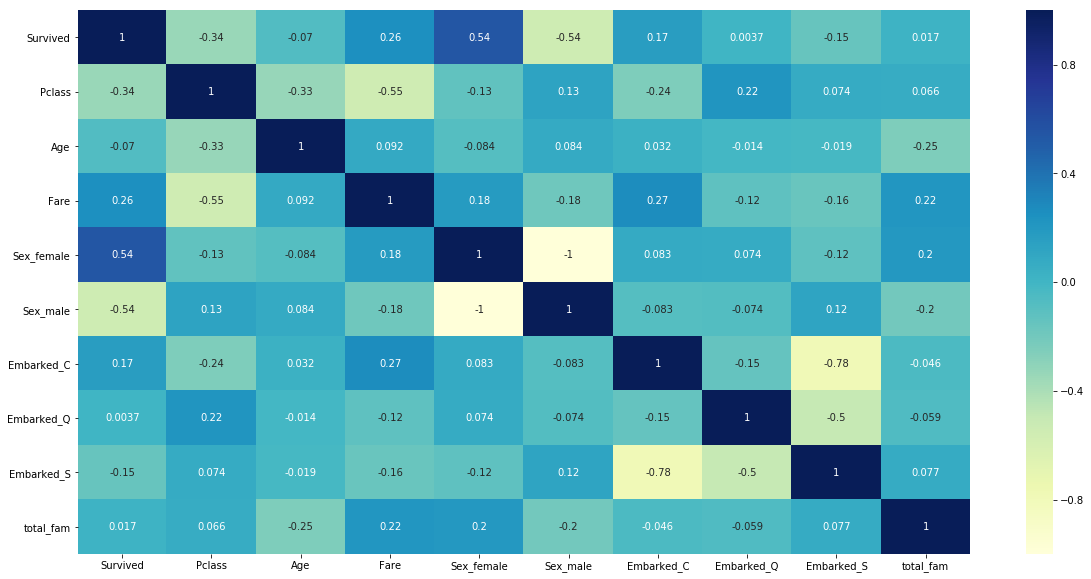

In [134]:
corr = df.corr() 
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, cmap="YlGnBu", annot=True) 

### Convertir los datos a una unica escala

In [135]:
X = df.drop('Survived',axis=1).values
y = df['Survived'].values

X_testing = df_test.values

In [136]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_testing = scaler.fit_transform(X_testing)

In [137]:
X_testing.shape

(418, 9)

In [138]:
#pca = PCA(n_components=None)
#X = pca.fit_transform(X)

In [139]:
#X_testing = pca.fit_transform(X_testing)

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y)

In [141]:
print("La forma de entrenamiento es {}".format(X_train.shape))
print("La forma de test es {}".format(X_test.shape))

La forma de entrenamiento es (623, 9)
La forma de test es (268, 9)


# Usamos SVC como primer modelo

In [142]:
model_1 = SVC()
param_grid = {"C": np.arange(2,20),
              "gamma":  np.logspace(-3, 2, 6),
              "kernel": ['linear','rbf']}
rs_SVC = RandomizedSearchCV(model_1,param_distributions=param_grid, n_iter=20, cv=5, n_jobs=4)
rs_SVC.fit(X_train,y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=20, n_jobs=4,
          param_distributions={'C': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19]), 'gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]), 'kernel': ['linear', 'rbf']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [143]:
rs_SVC.best_score_

0.8202247191011236

In [144]:
model_1 = rs_SVC.best_estimator_
model_1.fit(X_train,y_train)
model_1.score(X_test,y_test)

0.7947761194029851

In [145]:
y_pred = model_1.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[146  19]
 [ 36  67]]
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       165
           1       0.78      0.65      0.71       103

   micro avg       0.79      0.79      0.79       268
   macro avg       0.79      0.77      0.78       268
weighted avg       0.79      0.79      0.79       268



# Usamos Random Forest como modelo

In [146]:
rfc=RandomForestClassifier(random_state=42)

In [147]:
param_grid = {"n_estimators":np.arange(200,500),
              "max_features": ['auto', 'sqrt', 'log2'],
             "max_depth":np.arange(1,10),
              "criterion" :['gini', 'entropy']
             }

In [148]:
rs_RDC = RandomizedSearchCV(estimator=rfc,param_distributions=param_grid,n_iter=20, cv=5, n_jobs=4)
rs_RDC.fit(X_train,y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=20, n_jobs=4,
          param_distributions={'n_estimators': array([200, 201, ..., 498, 499]), 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]), 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [149]:
model_2 = rs_RDC.best_estimator_

In [150]:
rs_RDC.best_score_

0.8282504012841091

In [151]:
model_2.score(X_test,y_test)

0.8246268656716418

In [152]:
model_2.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=416, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [153]:
y_pred2 = model_2.predict(X_test)

In [154]:
print(confusion_matrix(y_test,y_pred2))
print(classification_report(y_test,y_pred2))

[[149  16]
 [ 31  72]]
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       165
           1       0.82      0.70      0.75       103

   micro avg       0.82      0.82      0.82       268
   macro avg       0.82      0.80      0.81       268
weighted avg       0.82      0.82      0.82       268



# Probando con datos de test

In [155]:
y_pred_testing = model_2.predict(X_testing)

In [156]:
df_test = pd.read_csv('test.csv')

In [157]:
submission = pd.DataFrame({
        "PassengerId": df_test["PassengerId"],
        "Survived": y_pred_testing
    })

In [158]:
submission.to_csv("submission.csv",index=False)